# Task 4 
\
**This task requires me to create 5 clusters for GDP and Volume of exports of goods data from the IMF 2020 OCT data**

First we read the data from the .pkl.
Note: Please run the Setup script if not done yet.

In [1]:
import pandas as pd
imf_data = pd.read_pickle("IMF_DATA.pkl")

Then we filter the data we want to keep.
\
\
In this step we must be careful of the amount of data we leave as there are more then one Subject Descriptor that contains the gdp_pattern, however only 'Gross domestic product, current prices' is denominated in U.S. dollars and has 195 rows which fits our export_data.
\
\
**Note: export_data is denoted in percent change from last years exports and gdp is denoted in billions of U.S. dollars**

In [2]:
gdp_pattern = 'Gross domestic product.(?!per capita).*'
export_pattern = 'Volume of exports of goods$'

gdp_data = imf_data[imf_data['Subject Descriptor'].str.contains(gdp_pattern, regex = True)]
export_data = imf_data[imf_data['Subject Descriptor'].str.contains(export_pattern, regex = True)]

usd_pattern = 'U.S. dollars'
gdp_data = gdp_data[gdp_data['Units'].str.contains(usd_pattern, regex = True)]

Next we set the predictions to 0, this function is the same we use in other tasks, with a few minor changes.

In [3]:
def remove_predictions(row):
    DATA_END_DATE = 2025
    DATA_START_DATE = 1980
    
    prediction_start_year = int(row['Estimates Start After'])
    
    if prediction_start_year < DATA_START_DATE:
        row.loc[DATA_START_DATE : DATA_END_DATE] = 0
    elif prediction_start_year < DATA_END_DATE:
        row.loc[prediction_start_year + 1 : DATA_END_DATE] = 0
        
    return row

gdp_data = gdp_data.apply(remove_predictions, axis = 1)
export_data = export_data.apply(remove_predictions, axis = 1)

In [4]:
# Setting the country as the index for the next step
gdp_data.set_index('Country', inplace = True)
export_data.set_index('Country', inplace = True)

# Leaving only the columns that have numberical data
gdp_data = gdp_data.loc[:, 1980 : 2019]
export_data = export_data.loc[:, 1980 : 2019]

In [5]:
# Reseting the index
gdp_data = gdp_data.reset_index()
export_data = export_data.reset_index()

In [6]:
# Transposing the data from wide format to long
long_gdp_data = gdp_data.melt(id_vars = 'Country', var_name='Year', value_name='GDP')
long_export_data = export_data.melt(id_vars = 'Country', var_name='Year', value_name='Export Volume')

# Merging the two data frames
merged_data = long_gdp_data.merge(long_export_data, on = ['Country', 'Year'], how = 'outer')

# Here I drop rows from merged_data where Export volume and GDP is 0.0
row_indexes_to_be_dropped = merged_data[(merged_data['GDP'] == 0) | (merged_data['Export Volume'] == 0)].index
merged_data = merged_data.drop(row_indexes_to_be_dropped)

**Note: when we transposed gdp_data and export_data to the long format and merged them there now is only 4 columns ('Country', 'Year', 'GDP', 'Export Volume')**
\
\
Now when we are finished with data cleaning we can start clustering it.

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_init = 20)

# Fitting kmeans with X where there is no string columns and then writing the results to merged_data['Cluster']
X = merged_data[['GDP', 'Export Volume']] # We only take the GDP and Export Volume columns
merged_data['Cluster'] = kmeans.fit_predict(X)
merged_data['Cluster'] = merged_data['Cluster'].astype('category')

In [8]:
merged_data['Merged Name'] = merged_data['Country'] + ' - ' + merged_data['Year'].astype('str')
top_5_countries = merged_data.nlargest(5, 'GDP') # Finding the 5 biggest GDP numbers

Now it is time to plot our findings.

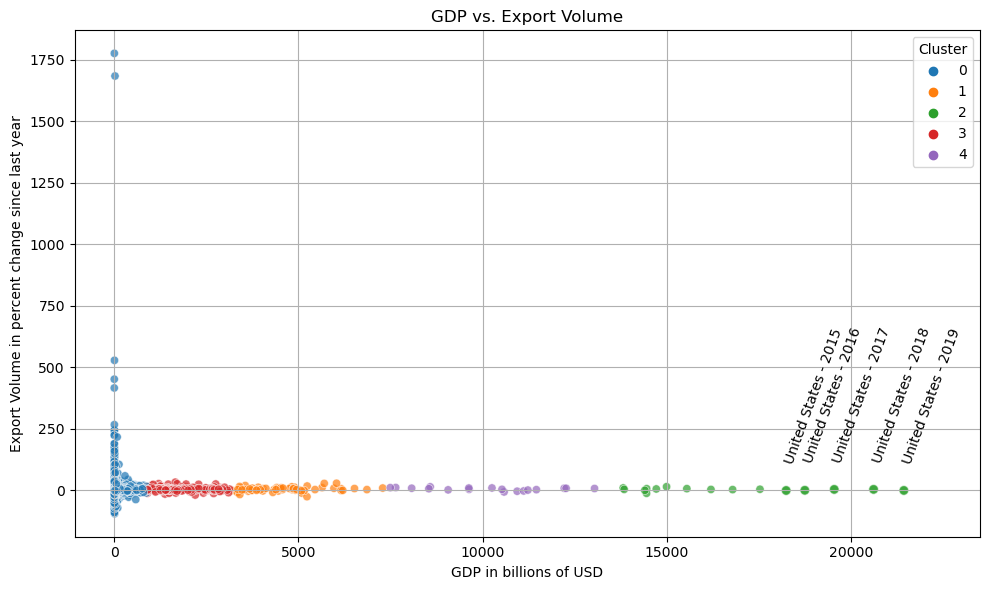

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP', y='Export Volume', data=merged_data, hue = 'Cluster', alpha=0.7)
sns.scatterplot(x='GDP', y='Export Volume', data=top_5_countries, hue = 'Cluster', s=50, legend=False, alpha=0.7)

# Label the top 5 countries on the scatter plot
for i, row in top_5_countries.iterrows():
    plt.annotate(row['Merged Name'], (row['GDP'], row['Export Volume']), 
                 xytext=(20, 20), textcoords='offset points', rotation=70, ha='center', fontsize=10)

plt.xlabel('GDP in billions of USD')
plt.ylabel('Export Volume in percent change since last year')
plt.title('GDP vs. Export Volume')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.xlim(right = 23500)
plt.tight_layout()
plt.show()

As we can see the U.S. has dominated the top 5 gdp list and with every new year the gap between other countries widen.